In [1]:
%matplotlib nbagg

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

Hardware information:
```
Model name:          Intel(R) Xeon(R) CPU E3-1505M v5 @ 2.80GHz
Thread(s) per core:  2
Core(s) per socket:  4
Socket(s):           1
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            8192K
```

In [3]:
import numpy as np
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


OpenBLAS version:
```
$ dpkg -l libopenblas-base
ii  libopenblas-base:amd64   0.2.20+ds-4       amd64             Optimized BLAS (linear algebra) library (shared libra
```

In [4]:
import gc
import time
import seaborn
import pandas as pd
import matplotlib.pyplot as plt
from libertem.io.dataset.hdf5 import H5DataSet
from libertem.io.dataset.hdfs import BinaryHDFSDataSet
from libertem.executor.dask import DaskJobExecutor
from libertem.job.masks import ApplyMasksJob

/home/clausen/.virtualenvs/libertem/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [5]:
def make_masks(n=5, shape=(128, 128)):
    masks=[
        lambda: np.random.randn(*shape)
        for i in range(n)
    ]
    return masks

In [11]:
executor = DaskJobExecutor.make_local(cluster_kwargs={"threads_per_worker": 1, "n_workers": 1})
# executor = DaskJobExecutor(scheduler_uri="tcp://localhost:8786")


masks = make_masks(n=16)

def process_with_params(num_masks, stackheight):
    ds = BinaryHDFSDataSet(index_path="/test/index.json", host='localhost', port=8020, tileshape=(1, stackheight, 128, 128))
    job = ApplyMasksJob(dataset=ds, mask_factories=masks[:num_masks])
    for result in executor.run_job(job):
        for tile in result:
            pass
    # TODO: ds.close()

In [13]:
%time process_with_params(num_masks=1, stackheight=8)

CPU times: user 245 ms, sys: 43.8 ms, total: 289 ms
Wall time: 1.09 s


In [14]:
results = []
for n_workers in range(1, 9):
    cluster = executor.client.cluster
    cluster.scale_up(n_workers, ncores=1)
    for num_masks in [1, 2, 4, 8, 16]:
        for stackheight in [4, 8]:
            for repeat in range(3):
                gc.collect()
                t0 = time.time()
                process_with_params(num_masks=num_masks + 1, stackheight=stackheight)
                t1 = time.time()
                result = {
                    "num_masks": num_masks,
                    "n_workers": n_workers,
                    "stackheight": stackheight,
                    "time": t1 - t0,
                }
                results.append(result)
                print(result)

{'num_masks': 1, 'n_workers': 1, 'stackheight': 4, 'time': 2.2843596935272217}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 4, 'time': 2.200774908065796}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 4, 'time': 2.286098003387451}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 8, 'time': 1.8917052745819092}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 8, 'time': 1.9091999530792236}
{'num_masks': 1, 'n_workers': 1, 'stackheight': 8, 'time': 1.900893211364746}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 4, 'time': 2.6782169342041016}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 4, 'time': 2.7789499759674072}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 4, 'time': 2.6540112495422363}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 8, 'time': 2.2629542350769043}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 8, 'time': 2.2806808948516846}
{'num_masks': 2, 'n_workers': 1, 'stackheight': 8, 'time': 2.3068854808807373}
{'num_masks': 4, 'n_workers': 1, 'stackheight': 4, 'tim

distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 1, 'stackheight': 8, 'time': 3.1759493350982666}
{'num_masks': 16, 'n_workers': 1, 'stackheight': 8, 'time': 3.2638323307037354}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 2, 'stackheight': 4, 'time': 1.342029333114624}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 2, 'stackheight': 4, 'time': 1.2849011421203613}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 2, 'stackheight': 4, 'time': 1.2366390228271484}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 2, 'stackheight': 8, 'time': 1.0511102676391602}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 2, 'stackheight': 8, 'time': 1.0730791091918945}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 2, 'stackheight': 8, 'time': 1.043600082397461}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 2, 'stackheight': 4, 'time': 1.4675140380859375}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 2, 'stackheight': 4, 'time': 1.5089867115020752}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 2, 'stackheight': 4, 'time': 1.4825708866119385}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 2, 'stackheight': 8, 'time': 1.2474253177642822}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 2, 'stackheight': 8, 'time': 1.2633893489837646}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 2, 'stackheight': 8, 'time': 1.2420499324798584}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 2, 'stackheight': 4, 'time': 1.6078071594238281}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 2, 'stackheight': 4, 'time': 1.5978991985321045}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 2, 'stackheight': 4, 'time': 1.6258296966552734}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 2, 'stackheight': 8, 'time': 1.3665297031402588}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 2, 'stackheight': 8, 'time': 1.3624229431152344}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 2, 'stackheight': 8, 'time': 1.32814359664917}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 2, 'stackheight': 4, 'time': 1.8711307048797607}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 2, 'stackheight': 4, 'time': 1.8928630352020264}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 2, 'stackheight': 4, 'time': 1.9427008628845215}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 2, 'stackheight': 8, 'time': 1.603440284729004}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 2, 'stackheight': 8, 'time': 1.5122416019439697}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 2, 'stackheight': 8, 'time': 1.4678490161895752}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 2, 'stackheight': 4, 'time': 2.5678398609161377}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 2, 'stackheight': 4, 'time': 2.55597186088562}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 2, 'stackheight': 4, 'time': 2.6622209548950195}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 2, 'stackheight': 8, 'time': 1.7942354679107666}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 2, 'stackheight': 8, 'time': 1.8958323001861572}
{'num_masks': 16, 'n_workers': 2, 'stackheight': 8, 'time': 1.8718068599700928}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 4, 'time': 1.031109094619751}


distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 4, 'time': 1.0163195133209229}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 4, 'time': 1.0718193054199219}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 8, 'time': 0.9277801513671875}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 8, 'time': 0.8753650188446045}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 3, 'stackheight': 8, 'time': 0.9050571918487549}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 4, 'time': 1.192591667175293}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 4, 'time': 1.1841461658477783}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 4, 'time': 1.1980745792388916}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 8, 'time': 1.0339365005493164}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 8, 'time': 1.0571398735046387}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 3, 'stackheight': 8, 'time': 0.9922096729278564}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 4, 'time': 1.3046956062316895}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 4, 'time': 1.2929513454437256}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 4, 'time': 1.3045539855957031}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 8, 'time': 1.0672187805175781}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 8, 'time': 1.0189628601074219}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 3, 'stackheight': 8, 'time': 1.0924742221832275}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 4, 'time': 1.450918436050415}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 4, 'time': 1.4169998168945312}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 4, 'time': 1.5526206493377686}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 8, 'time': 1.308805227279663}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 8, 'time': 1.2961359024047852}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 3, 'stackheight': 8, 'time': 1.2058918476104736}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 4, 'time': 2.0938100814819336}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 4, 'time': 2.0496041774749756}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 4, 'time': 1.9482886791229248}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 8, 'time': 1.4436163902282715}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 3, 'stackheight': 8, 'time': 1.4448869228363037}
{'num_masks': 16, 'n_workers': 3, 'stackheight': 8, 'time': 1.5428800582885742}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 4, 'time': 0.8833813667297363}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 4, 'time': 0.846259593963623}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 4, 'time': 0.8673086166381836}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 8, 'time': 0.7098124027252197}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 8, 'time': 0.7333743572235107}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 4, 'stackheight': 8, 'time': 0.6877820491790771}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 4, 'time': 0.9592459201812744}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 4, 'time': 0.994985818862915}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 4, 'time': 0.9823062419891357}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 8, 'time': 0.8746514320373535}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 8, 'time': 0.8327968120574951}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 4, 'stackheight': 8, 'time': 0.8784613609313965}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 4, 'time': 1.0693516731262207}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 4, 'time': 1.0470523834228516}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 4, 'time': 1.0489404201507568}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 8, 'time': 0.8435215950012207}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 8, 'time': 0.8169825077056885}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 4, 'stackheight': 8, 'time': 0.90126633644104}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 4, 'time': 1.2785959243774414}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 4, 'time': 1.272406816482544}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 4, 'time': 1.3209071159362793}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 8, 'time': 1.0823378562927246}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 8, 'time': 0.9937891960144043}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 4, 'stackheight': 8, 'time': 0.978830099105835}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 4, 'time': 1.7378530502319336}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 4, 'time': 1.8634533882141113}


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 4, 'time': 1.7348194122314453}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 8, 'time': 1.2182843685150146}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 4, 'stackheight': 8, 'time': 1.2907545566558838}
{'num_masks': 16, 'n_workers': 4, 'stackheight': 8, 'time': 1.2863407135009766}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 4, 'time': 0.7836499214172363}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 4, 'time': 0.7931466102600098}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 4, 'time': 0.7856605052947998}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 8, 'time': 0.7302074432373047}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 8, 'time': 0.6686630249023438}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 5, 'stackheight': 8, 'time': 0.6509106159210205}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 4, 'time': 0.9503645896911621}


distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 4, 'time': 0.9680521488189697}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 4, 'time': 0.923823356628418}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 8, 'time': 0.8807804584503174}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 8, 'time': 0.8015854358673096}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 5, 'stackheight': 8, 'time': 0.8206775188446045}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 4, 'time': 1.024226427078247}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 4, 'time': 1.0284669399261475}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 4, 'time': 1.0936214923858643}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 8, 'time': 0.8338215351104736}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 8, 'time': 0.8329994678497314}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 5, 'stackheight': 8, 'time': 0.8854246139526367}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 4, 'time': 1.1579444408416748}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 4, 'time': 1.195577621459961}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 4, 'time': 1.2051329612731934}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 8, 'time': 1.0069198608398438}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 8, 'time': 1.007406234741211}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 5, 'stackheight': 8, 'time': 1.0119102001190186}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 4, 'time': 1.690354347229004}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 4, 'time': 1.6535193920135498}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 4, 'time': 1.6297099590301514}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 8, 'time': 1.1839654445648193}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 5, 'stackheight': 8, 'time': 1.1572601795196533}
{'num_masks': 16, 'n_workers': 5, 'stackheight': 8, 'time': 1.1558215618133545}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 4, 'time': 0.7519111633300781}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 4, 'time': 0.7169134616851807}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 4, 'time': 0.7427663803100586}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 8, 'time': 0.6027750968933105}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 8, 'time': 0.6292424201965332}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 6, 'stackheight': 8, 'time': 0.6311650276184082}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 4, 'time': 0.8283402919769287}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 4, 'time': 0.8050966262817383}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 4, 'time': 0.842231273651123}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 8, 'time': 0.7478015422821045}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 8, 'time': 0.722461462020874}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 6, 'stackheight': 8, 'time': 0.7097492218017578}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 4, 'time': 0.903005838394165}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 4, 'time': 0.874645471572876}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 4, 'time': 0.926973819732666}


distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 8, 'time': 0.7854151725769043}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 8, 'time': 0.7637457847595215}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 6, 'stackheight': 8, 'time': 0.7503035068511963}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 4, 'time': 1.1435983180999756}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 4, 'time': 1.0957615375518799}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 4, 'time': 1.0790159702301025}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 8, 'time': 0.8953311443328857}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 8, 'time': 0.9063656330108643}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 6, 'stackheight': 8, 'time': 0.9226253032684326}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 4, 'time': 1.583597183227539}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 4, 'time': 1.5775482654571533}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 4, 'time': 1.5646748542785645}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 8, 'time': 1.1014928817749023}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 6, 'stackheight': 8, 'time': 1.1928558349609375}
{'num_masks': 16, 'n_workers': 6, 'stackheight': 8, 'time': 1.2298877239227295}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 4, 'time': 0.6996922492980957}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 4, 'time': 0.7049551010131836}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 4, 'time': 0.6901652812957764}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 8, 'time': 0.6260957717895508}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 8, 'time': 0.6162283420562744}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 7, 'stackheight': 8, 'time': 0.6651167869567871}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 4, 'time': 0.7929348945617676}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 4, 'time': 0.8324315547943115}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 4, 'time': 0.8467588424682617}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 8, 'time': 0.730217695236206}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 8, 'time': 0.7437944412231445}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 7, 'stackheight': 8, 'time': 0.6996405124664307}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 4, 'time': 0.8991940021514893}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 4, 'time': 0.8465385437011719}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 4, 'time': 0.8633403778076172}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 8, 'time': 0.7448956966400146}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 8, 'time': 0.7630603313446045}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 7, 'stackheight': 8, 'time': 0.7353971004486084}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 4, 'time': 1.058619737625122}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 4, 'time': 1.1039018630981445}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 4, 'time': 1.143113374710083}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 8, 'time': 0.8445837497711182}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 8, 'time': 0.8811547756195068}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 7, 'stackheight': 8, 'time': 0.9244863986968994}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 4, 'time': 1.6211402416229248}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 4, 'time': 1.458526372909546}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 4, 'time': 1.5003986358642578}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 8, 'time': 1.0628657341003418}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 7, 'stackheight': 8, 'time': 1.2280352115631104}
{'num_masks': 16, 'n_workers': 7, 'stackheight': 8, 'time': 1.1354742050170898}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 4, 'time': 0.7230572700500488}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 4, 'time': 0.6994411945343018}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 4, 'time': 0.6941003799438477}


distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 8, 'time': 0.625777006149292}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 8, 'time': 0.5777561664581299}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 1, 'n_workers': 8, 'stackheight': 8, 'time': 0.6201701164245605}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 4, 'time': 0.7832562923431396}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 4, 'time': 0.8033888339996338}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 4, 'time': 0.787499189376831}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 8, 'time': 0.7096500396728516}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 8, 'time': 0.6973459720611572}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 2, 'n_workers': 8, 'stackheight': 8, 'time': 0.7263095378875732}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 4, 'time': 0.8624591827392578}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 4, 'time': 0.8684556484222412}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 4, 'time': 0.8347845077514648}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 8, 'time': 0.7086963653564453}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 8, 'time': 0.7320206165313721}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 4, 'n_workers': 8, 'stackheight': 8, 'time': 0.7222881317138672}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 4, 'time': 1.0983035564422607}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 4, 'time': 1.0940876007080078}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 4, 'time': 1.0590827465057373}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 8, 'time': 0.9115386009216309}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 8, 'time': 0.8931179046630859}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)


{'num_masks': 8, 'n_workers': 8, 'stackheight': 8, 'time': 0.8568413257598877}


distributed.utils_perf - WARNING - full garbage collections took 25% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 4, 'time': 1.466740608215332}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 4, 'time': 1.5495202541351318}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 4, 'time': 1.5253920555114746}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 8, 'time': 1.0898056030273438}


distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


{'num_masks': 16, 'n_workers': 8, 'stackheight': 8, 'time': 1.1862730979919434}
{'num_masks': 16, 'n_workers': 8, 'stackheight': 8, 'time': 1.1212384700775146}


distributed.utils - ERROR - Worker failed to start
Traceback (most recent call last):
  File "/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/distributed/utils.py", line 646, in log_errors
    yield
  File "/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/distributed/deploy/local.py", line 307, in scale_up
    for i in range(n - len(self.scheduler.workers))]
  File "/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/tornado/gen.py", line 1133, in run
    value = future.result()
  File "/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/tornado/gen.py", line 883, in callback
    result_list.append(f.result())
  File "/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/distributed/deploy/local.py", line 215, in _start_worker
    raise gen.TimeoutError("Worker failed to start")
tor

distributed.utils - ERROR - Worker failed to start
Traceback (most recent call last):
  File "/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/distributed/utils.py", line 646, in log_errors
    yield
  File "/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/distributed/deploy/local.py", line 307, in scale_up
    for i in range(n - len(self.scheduler.workers))]
  File "/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/tornado/gen.py", line 1133, in run
    value = future.result()
  File "/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/tornado/gen.py", line 883, in callback
    result_list.append(f.result())
  File "/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/distributed/deploy/local.py", line 215, in _start_worker
    raise gen.TimeoutError("Worker failed to start")
tor

In [15]:
df = pd.DataFrame(results)

<IPython.core.display.Javascript object>


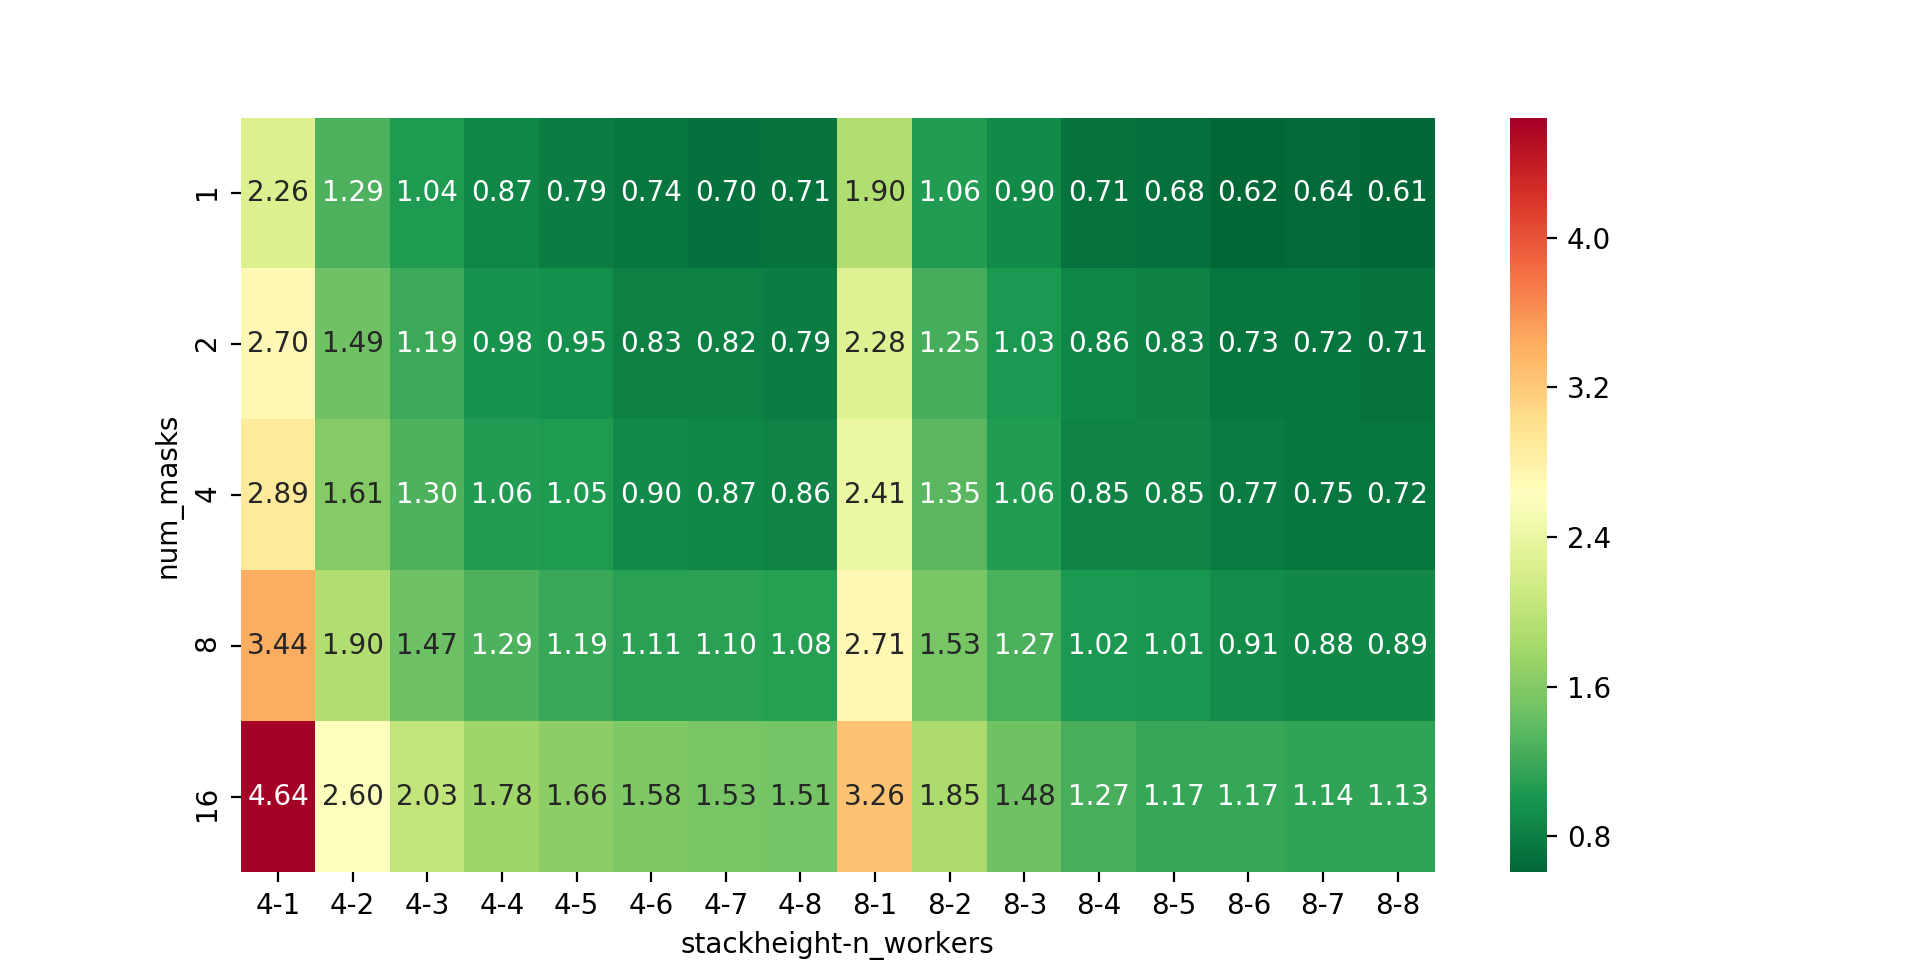

In [16]:
table = df.pivot_table(values='time', columns=['stackheight', "n_workers"], index=["num_masks"])
cmap = "RdYlGn_r"
seaborn.heatmap(table, annot=True, cmap=cmap, fmt=".2f")
plt.show()

<IPython.core.display.Javascript object>


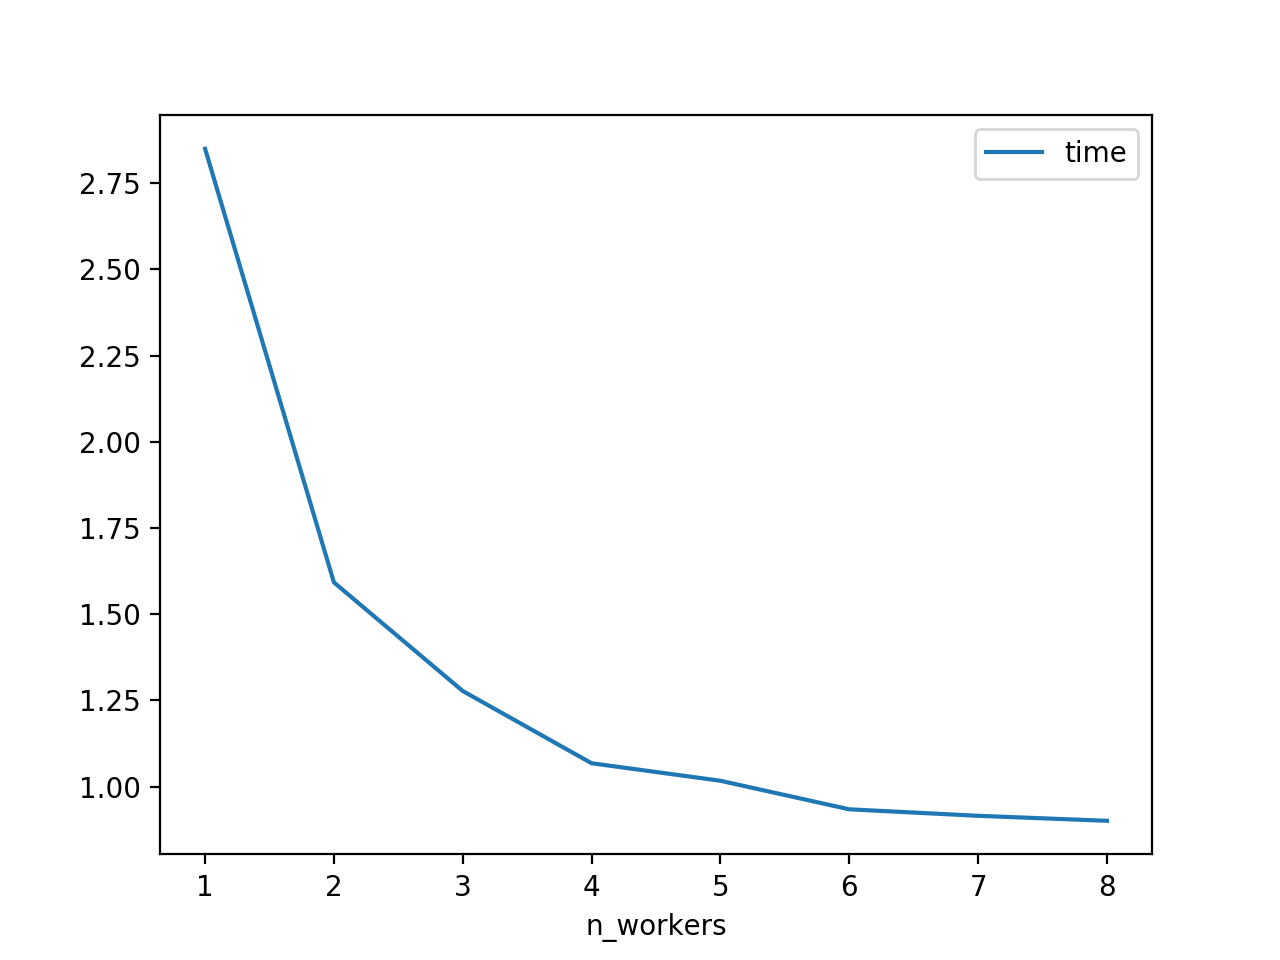

In [17]:
df.groupby(["n_workers"]).mean()[["time"]].plot()

In [21]:
df2 = pd.merge(
    df[df.stackheight == 4].groupby("n_workers")["n_workers", "time"].mean(),
    df[df.stackheight == 8].groupby("n_workers")["n_workers", "time"].mean(),
    on="n_workers",
)

/home/clausen/.virtualenvs/libertem/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: FutureWarning: 'n_workers' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [22]:
df2

,n_workers,time_x,time_y
0,1,3.186350,2.513251
1,2,1.776460,1.408210
2,3,1.407234,1.147491
3,4,1.193791,0.941932
4,5,1.125550,0.908557
5,6,1.029072,0.839415
6,7,1.004114,0.826736
7,8,0.989971,0.811922


<IPython.core.display.Javascript object>


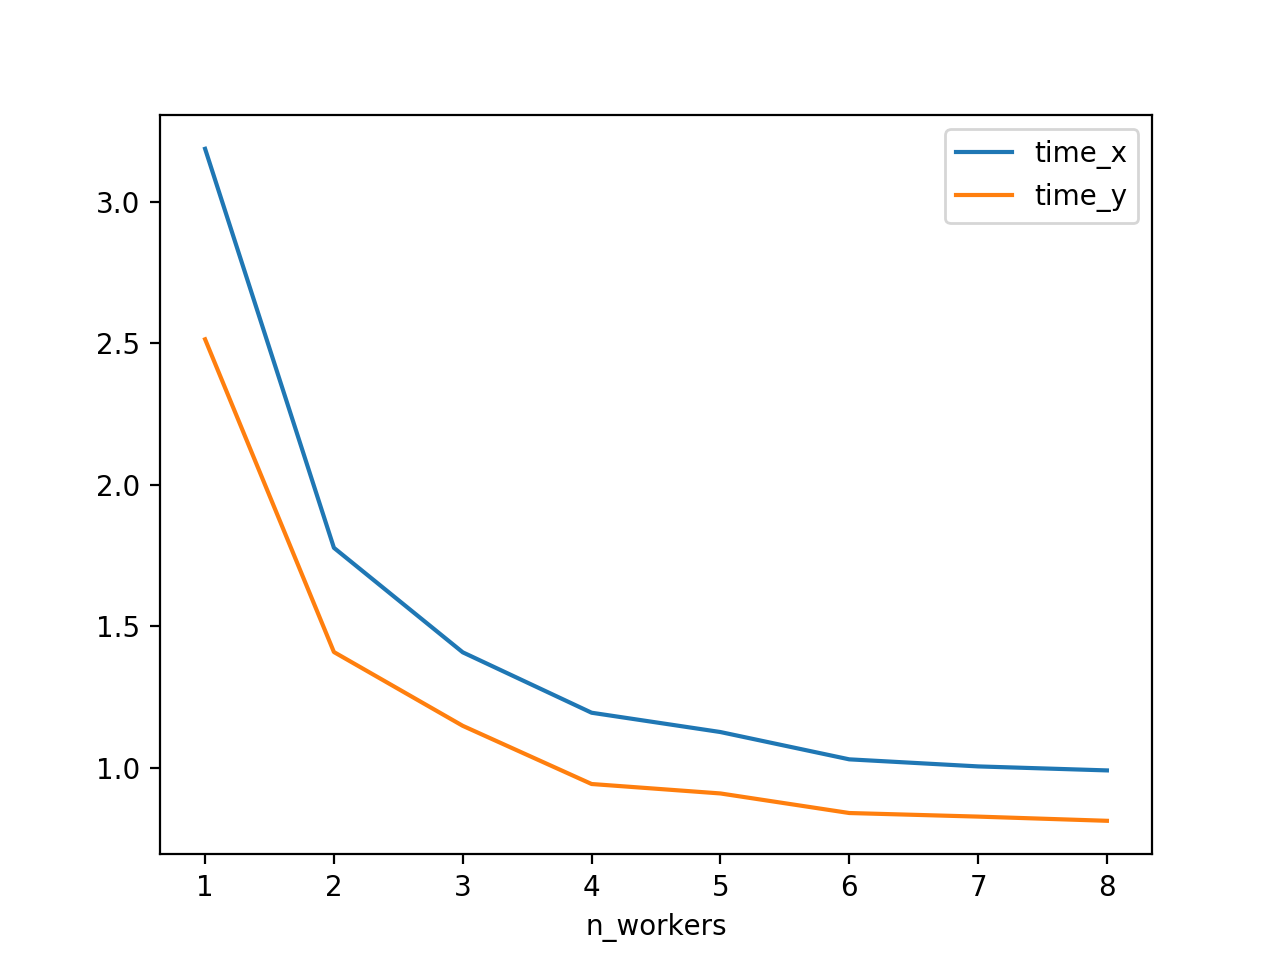

In [23]:
df2.set_index('n_workers').plot()

In [20]:
len(results)

240